# Imports & Drive

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

%cd drive/MyDrive/ProjectML/data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1IxvmZcUIWJGfT71uBwgUz69EsWaNvayC/ProjectML/data


In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import models, transforms
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Loading & Preprocessing

In [ ]:
TRAIN_PATH = "training.npz"
TEST_PATH  = "testing.npz"

In [ ]:
train_npz = np.load(TRAIN_PATH, allow_pickle=True)
test_npz  = np.load(TEST_PATH,  allow_pickle=True)

X_full      = train_npz['images']
y_full      = train_npz['labels']
class_names = train_npz['class_names']

X_test = test_npz['images']
y_test = test_npz['labels']

print("Full (to split):", X_full.shape, y_full.shape)
print("Test:", X_test.shape, y_test.shape)
print("Class names:", class_names)

X_train, X_val, y_train, y_val = train_test_split(
    X_full, y_full,
    test_size=0.2,
    random_state=42,
    stratify=y_full
)

print("Train:", X_train.shape, y_train.shape)
print("Val:",   X_val.shape,   y_val.shape)
print("Test:",  X_test.shape,  y_test.shape)

Full (to split): (5712, 256, 256, 3) (5712,)
Test: (1311, 256, 256, 3) (1311,)
Class names: ['glioma' 'meningioma' 'notumor' 'pituitary']
Train: (4569, 256, 256, 3) (4569,)
Val: (1143, 256, 256, 3) (1143,)
Test: (1311, 256, 256, 3) (1311,)


In [ ]:
from PIL import Image

#first experiment
class NumpyDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        img = self.X[idx]
        label = self.y[idx]

        if img.ndim == 3 and img.shape[-1] in [1, 3]:
            pass
        else:
            raise ValueError(f"Image with shape not compatible: {img.shape}")

        if img.dtype != np.uint8:
            img = (img * 255).astype(np.uint8)
        img = Image.fromarray(img)

        if self.transform:
            img = self.transform(img)

        label = torch.tensor(label).long()
        return img, label


"""
#experiment
class TargetedAugmentDataset(Dataset):
    def __init__(self, X, y, strong_classes=[0,1], transform_basic=None, transform_strong=None):
        self.X = X
        self.y = y
        self.strong_classes = strong_classes  # es: [0,1] = glioma, meningioma
        self.transform_basic = transform_basic
        self.transform_strong = transform_strong

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        img = self.X[idx]
        label = self.y[idx]

        if img.dtype != np.uint8:
            img = (img * 255).astype(np.uint8)

        img = Image.fromarray(img)

        if label in self.strong_classes:
            if self.transform_strong:
                img = self.transform_strong(img)
        else:
            if self.transform_basic:
                img = self.transform_basic(img)

        label = torch.tensor(label).long()
        return img, label

#end experiment
"""


'\n#2nd experiment\nclass TargetedAugmentDataset(Dataset):\n    def __init__(self, X, y, strong_classes=[0,1], transform_basic=None, transform_strong=None):\n        self.X = X\n        self.y = y\n        self.strong_classes = strong_classes  # es: [0,1] = glioma, meningioma\n        self.transform_basic = transform_basic\n        self.transform_strong = transform_strong\n\n    def __len__(self):\n        return len(self.y)\n\n    def __getitem__(self, idx):\n        img = self.X[idx]\n        label = self.y[idx]\n\n        if img.dtype != np.uint8:\n            img = (img * 255).astype(np.uint8)\n\n        img = Image.fromarray(img)\n\n        if label in self.strong_classes:\n            if self.transform_strong:\n                img = self.transform_strong(img)\n        else:\n            if self.transform_basic:\n                img = self.transform_basic(img)\n\n        label = torch.tensor(label).long()\n        return img, label\n\n#end 2nd experiment\n'

In [ ]:

#first experiment
data_transforms = {
    #more augmentation becauase no pretrained data
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.RandomResizedCrop(size=(X_train.shape[1], X_train.shape[2]), scale=(0.9,1.0)),
        transforms.ColorJitter(brightness=0.15, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ]),
}
"""
#experiment
# Augmentation STANDARD (easy classes)
basic_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

# Augmentation STRONG (glioma + meningioma)
strong_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(size=(X_train.shape[1], X_train.shape[2]), scale=(0.85,1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.25),
    transforms.RandomAffine(degrees=0, translate=(0.05,0.05)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])
#end experiment
"""
batch_size = 32
num_workers = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#first experiment
train_ds = NumpyDataset(X_train, y_train, transform=data_transforms['train'])
val_ds   = NumpyDataset(X_val,   y_val,   transform=data_transforms['val'])
test_ds  = NumpyDataset(X_test,  y_test,  transform=data_transforms['test'])

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=num_workers, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

"""
experiment
train_ds = TargetedAugmentDataset(
    X_train, y_train,
    strong_classes=[0,1],
    transform_basic=basic_transform,
    transform_strong=strong_transform
)

val_ds = NumpyDataset(X_val, y_val, transform=basic_transform)
test_ds = NumpyDataset(X_test, y_test, transform=basic_transform)
"""
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, num_workers=2)

dataset_sizes = {'train': len(train_ds), 'val': len(val_ds), 'test': len(test_ds)}
print(dataset_sizes)

#experiment
class_weights = torch.tensor([1.0, 1.4, 1.0, 1.0], dtype=torch.float).to(device)
#end experiment

{'train': 4569, 'val': 1143, 'test': 1311}


# Model

In [ ]:
num_classes = len(np.unique(y_train))
"""
model = models.mobilenet_v2(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

# Freeze
for param in model.features.parameters():
    param.requires_grad = False
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-3)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
"""


'\nmodel = models.mobilenet_v2(pretrained=True)\nnum_ftrs = model.classifier[1].in_features\nmodel.classifier[1] = nn.Linear(num_ftrs, num_classes)\nmodel = model.to(device)\n\n# Freeze\nfor param in model.features.parameters():\n    param.requires_grad = False\ncriterion = nn.CrossEntropyLoss()\noptimizer = optim.Adam(model.classifier.parameters(), lr=1e-3)\nexp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)\n'

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        #Kernel 3x3 standard
        #Padding = 1 -> preserve spatial dimension (needed for fully connected layer)
        #channels: 32->64->128->256
        #maxPool2d = 2 -> halves H and W at each layer, making the model more robust and reducing parameters
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.pool = nn.AdaptiveAvgPool2d((1,1))

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256*1*1, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x) #reduce HxW to 1x1
        x = self.classifier(x)
        return x
model = SimpleCNN(num_classes=num_classes).to(device)
"""
#experiment
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, weight=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.weight = weight
        self.ce = nn.CrossEntropyLoss(weight=weight)

    def forward(self, inputs, targets):
        logp = self.ce(inputs, targets)
        p = torch.exp(-logp)
        loss = ((1 - p) ** self.gamma * logp).mean()
        return loss
"""

criterion = nn.CrossEntropyLoss(weight=class_weights)
#criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)

#end experiment

"""first experiment
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)
"""

'first experiment\ncriterion = nn.CrossEntropyLoss()\noptimizer = optim.Adam(model.parameters(), lr=1e-3)\nexp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)\n'

# Training

**Early stopping logic**

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0, verbose=False):
        """
        Args:
            patience (int): how many epochs to wait after last improvement
            min_delta (float): minimal change to qualify as an improvement
            verbose (bool): whether to print when early‐stop is triggered
        """
        self.patience    = patience
        self.min_delta   = min_delta
        self.verbose     = verbose
        self.best_loss   = float('inf')
        self.counter     = 0
        self.early_stop  = False

    def __call__(self, val_loss, model, best_model_wts):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss  = val_loss
            self.counter    = 0
            best_model_wts  = model.state_dict().copy()
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        return best_model_wts


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5, early_stopping=None):
    best_model_wts = model.state_dict().copy()
    best_acc = 0.0

    history = {
        'train_loss': [],
        'val_loss':   [],
        'train_acc':  [],
        'val_acc':    []
    }

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print('-'*20)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            with tqdm(dataloader, unit="batch", desc=f"{phase} Epoch {epoch+1}") as tepoch:
                for inputs, labels in tepoch:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                    current_loss = running_loss / ((tepoch.n * tepoch.last_print_n) if tepoch.last_print_n else 1)
                    tepoch.set_postfix(loss=f"{loss.item():.4f}")

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc  = running_corrects.double() / dataset_sizes[phase]

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

                if early_stopping is not None:
                    best_model_wts = early_stopping(epoch_loss, model, best_model_wts)
                    if early_stopping.early_stop:
                        print("Early stopping triggered.")
                        model.load_state_dict(best_model_wts)
                        return model, history

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict().copy()



    print(f"Best val Acc: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model, history


**Hyperparamms**

In [ ]:

es = EarlyStopping(patience=5, min_delta=0.01, verbose=True)
model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=40, early_stopping=es)

"""LR = 1e-5
STEP_SIZE = 7
GAMMA = 0.1
EPOCHS = 30
BATCH_SIZE = 32
PATIENCE = 3
"""

Epoch 1/40
--------------------


train Epoch 1:   0%|          | 0/143 [00:00<?, ?batch/s]

train Loss: 1.2013 Acc: 0.4036


val Epoch 1:   0%|          | 0/36 [00:00<?, ?batch/s]

val Loss: 1.0838 Acc: 0.4751
Epoch 2/40
--------------------


train Epoch 2:   0%|          | 0/143 [00:00<?, ?batch/s]

train Loss: 1.1352 Acc: 0.4607


val Epoch 2:   0%|          | 0/36 [00:00<?, ?batch/s]

val Loss: 1.0637 Acc: 0.4917
Epoch 3/40
--------------------


train Epoch 3:   0%|          | 0/143 [00:00<?, ?batch/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b1ea4211d00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
Exception ignored in:   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7b1ea4211d00>assert self._parent_pid == os.getpid(), 'can only test a child process'

Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
      self._shutdown_workers() 
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
       if w.is_alive():
       ^ ^  ^ ^^^^^^^^^^^^^^^^^^^^^^

train Loss: 1.1185 Acc: 0.4839


val Epoch 3:   0%|          | 0/36 [00:00<?, ?batch/s]

val Loss: 1.0192 Acc: 0.5171
Epoch 4/40
--------------------


train Epoch 4:   0%|          | 0/143 [00:00<?, ?batch/s]

train Loss: 1.0270 Acc: 0.5555


val Epoch 4:   0%|          | 0/36 [00:00<?, ?batch/s]

val Loss: 0.8675 Acc: 0.6194
Epoch 5/40
--------------------


train Epoch 5:   0%|          | 0/143 [00:00<?, ?batch/s]

train Loss: 0.9332 Acc: 0.6148


val Epoch 5:   0%|          | 0/36 [00:00<?, ?batch/s]

val Loss: 0.7946 Acc: 0.6789
Epoch 6/40
--------------------


train Epoch 6:   0%|          | 0/143 [00:00<?, ?batch/s]

train Loss: 0.8701 Acc: 0.6422


val Epoch 6:   0%|          | 0/36 [00:00<?, ?batch/s]

val Loss: 0.6730 Acc: 0.7419
Epoch 7/40
--------------------


train Epoch 7:   0%|          | 0/143 [00:00<?, ?batch/s]

train Loss: 0.7905 Acc: 0.6833


val Epoch 7:   0%|          | 0/36 [00:00<?, ?batch/s]

val Loss: 0.6072 Acc: 0.7743
Epoch 8/40
--------------------


train Epoch 8:   0%|          | 0/143 [00:00<?, ?batch/s]

train Loss: 0.6893 Acc: 0.7393


val Epoch 8:   0%|          | 0/36 [00:00<?, ?batch/s]

val Loss: 0.5805 Acc: 0.7638
Epoch 9/40
--------------------


train Epoch 9:   0%|          | 0/143 [00:00<?, ?batch/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b1ea4211d00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7b1ea4211d00>^^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    ^^if w.is_alive():^
^  ^ ^^  ^

train Loss: 0.6292 Acc: 0.7619


val Epoch 9:   0%|          | 0/36 [00:00<?, ?batch/s]

val Loss: 0.5425 Acc: 0.7927
Epoch 10/40
--------------------


train Epoch 10:   0%|          | 0/143 [00:00<?, ?batch/s]

train Loss: 0.5800 Acc: 0.7787


val Epoch 10:   0%|          | 0/36 [00:00<?, ?batch/s]

val Loss: 0.4755 Acc: 0.8338
Epoch 11/40
--------------------


train Epoch 11:   0%|          | 0/143 [00:00<?, ?batch/s]

train Loss: 0.5471 Acc: 0.7870


val Epoch 11:   0%|          | 0/36 [00:00<?, ?batch/s]

val Loss: 0.4409 Acc: 0.8329
Epoch 12/40
--------------------


train Epoch 12:   0%|          | 0/143 [00:00<?, ?batch/s]

train Loss: 0.5293 Acc: 0.7973


val Epoch 12:   0%|          | 0/36 [00:00<?, ?batch/s]

val Loss: 0.4752 Acc: 0.8268
EarlyStopping counter: 1 out of 5
Epoch 13/40
--------------------


train Epoch 13:   0%|          | 0/143 [00:00<?, ?batch/s]

train Loss: 0.5102 Acc: 0.8039


val Epoch 13:   0%|          | 0/36 [00:00<?, ?batch/s]

val Loss: 0.3865 Acc: 0.8626
Epoch 14/40
--------------------


train Epoch 14:   0%|          | 0/143 [00:00<?, ?batch/s]

train Loss: 0.4830 Acc: 0.8166


val Epoch 14:   0%|          | 0/36 [00:00<?, ?batch/s]

val Loss: 0.4480 Acc: 0.8460
EarlyStopping counter: 1 out of 5
Epoch 15/40
--------------------


train Epoch 15:   0%|          | 0/143 [00:00<?, ?batch/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b1ea4211d00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
     Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7b1ea4211d00> ^
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^^    ^if w.is_alive():^
^ ^
   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), 'can only test a child process'  
  ^ ^ ^    ^^ ^ ^ ^ ^^^^^^^^
^  File 

train Loss: 0.4472 Acc: 0.8372


val Epoch 15:   0%|          | 0/36 [00:00<?, ?batch/s]

val Loss: 0.3787 Acc: 0.8731
EarlyStopping counter: 2 out of 5
Epoch 16/40
--------------------


train Epoch 16:   0%|          | 0/143 [00:00<?, ?batch/s]

train Loss: 0.4239 Acc: 0.8402


val Epoch 16:   0%|          | 0/36 [00:00<?, ?batch/s]

val Loss: 0.3316 Acc: 0.8793
Epoch 17/40
--------------------


train Epoch 17:   0%|          | 0/143 [00:00<?, ?batch/s]

train Loss: 0.4074 Acc: 0.8525


val Epoch 17:   0%|          | 0/36 [00:00<?, ?batch/s]

val Loss: 0.3543 Acc: 0.8635
EarlyStopping counter: 1 out of 5
Epoch 18/40
--------------------


train Epoch 18:   0%|          | 0/143 [00:00<?, ?batch/s]

train Loss: 0.4013 Acc: 0.8483


val Epoch 18:   0%|          | 0/36 [00:00<?, ?batch/s]

val Loss: 0.3343 Acc: 0.8898
EarlyStopping counter: 2 out of 5
Epoch 19/40
--------------------


train Epoch 19:   0%|          | 0/143 [00:00<?, ?batch/s]

train Loss: 0.4199 Acc: 0.8461


val Epoch 19:   0%|          | 0/36 [00:00<?, ?batch/s]

val Loss: 0.3462 Acc: 0.8775
EarlyStopping counter: 3 out of 5
Epoch 20/40
--------------------


train Epoch 20:   0%|          | 0/143 [00:00<?, ?batch/s]

train Loss: 0.3786 Acc: 0.8669


val Epoch 20:   0%|          | 0/36 [00:00<?, ?batch/s]

val Loss: 0.3065 Acc: 0.8880
Epoch 21/40
--------------------


train Epoch 21:   0%|          | 0/143 [00:00<?, ?batch/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b1ea4211d00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7b1ea4211d00>^^
^^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^    ^self._shutdown_workers()^
^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    if w.is_alive():^
^^ ^^ ^  ^^^ ^ ^^^

train Loss: 0.3704 Acc: 0.8632


val Epoch 21:   0%|          | 0/36 [00:00<?, ?batch/s]

val Loss: 0.3036 Acc: 0.8863
EarlyStopping counter: 1 out of 5
Epoch 22/40
--------------------


train Epoch 22:   0%|          | 0/143 [00:00<?, ?batch/s]

train Loss: 0.3442 Acc: 0.8698


val Epoch 22:   0%|          | 0/36 [00:00<?, ?batch/s]

val Loss: 0.2848 Acc: 0.9064
Epoch 23/40
--------------------


train Epoch 23:   0%|          | 0/143 [00:00<?, ?batch/s]

train Loss: 0.3386 Acc: 0.8763


val Epoch 23:   0%|          | 0/36 [00:00<?, ?batch/s]

val Loss: 0.2887 Acc: 0.8968
EarlyStopping counter: 1 out of 5
Epoch 24/40
--------------------


train Epoch 24:   0%|          | 0/143 [00:00<?, ?batch/s]

train Loss: 0.3368 Acc: 0.8715


val Epoch 24:   0%|          | 0/36 [00:00<?, ?batch/s]

val Loss: 0.2853 Acc: 0.8994
EarlyStopping counter: 2 out of 5
Epoch 25/40
--------------------


train Epoch 25:   0%|          | 0/143 [00:00<?, ?batch/s]

train Loss: 0.3335 Acc: 0.8818


val Epoch 25:   0%|          | 0/36 [00:00<?, ?batch/s]

val Loss: 0.2693 Acc: 0.9020
Epoch 26/40
--------------------


train Epoch 26:   0%|          | 0/143 [00:00<?, ?batch/s]

train Loss: 0.3250 Acc: 0.8790


val Epoch 26:   0%|          | 0/36 [00:00<?, ?batch/s]

val Loss: 0.2863 Acc: 0.9064
EarlyStopping counter: 1 out of 5
Epoch 27/40
--------------------


train Epoch 27:   0%|          | 0/143 [00:00<?, ?batch/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b1ea4211d00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7b1ea4211d00>^^^
^Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
      File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
self._shutdown_workers()
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
assert self._parent_pid == os.getpid(), 'can only test a child process'    if w.is_alive():
 
                ^^^^ ^^^^^^^^^^^^^^^^^^
^^

train Loss: 0.3143 Acc: 0.8847


val Epoch 27:   0%|          | 0/36 [00:00<?, ?batch/s]

val Loss: 0.2613 Acc: 0.9073
EarlyStopping counter: 2 out of 5
Epoch 28/40
--------------------


train Epoch 28:   0%|          | 0/143 [00:00<?, ?batch/s]

train Loss: 0.3106 Acc: 0.8831


val Epoch 28:   0%|          | 0/36 [00:00<?, ?batch/s]

val Loss: 0.2833 Acc: 0.9055
EarlyStopping counter: 3 out of 5
Epoch 29/40
--------------------


train Epoch 29:   0%|          | 0/143 [00:00<?, ?batch/s]

train Loss: 0.2965 Acc: 0.8877


val Epoch 29:   0%|          | 0/36 [00:00<?, ?batch/s]

val Loss: 0.2539 Acc: 0.9134
Epoch 30/40
--------------------


train Epoch 30:   0%|          | 0/143 [00:00<?, ?batch/s]

train Loss: 0.2911 Acc: 0.8928


val Epoch 30:   0%|          | 0/36 [00:00<?, ?batch/s]

val Loss: 0.2533 Acc: 0.9073
EarlyStopping counter: 1 out of 5
Epoch 31/40
--------------------


train Epoch 31:   0%|          | 0/143 [00:00<?, ?batch/s]

train Loss: 0.2944 Acc: 0.8938


val Epoch 31:   0%|          | 0/36 [00:00<?, ?batch/s]

val Loss: 0.2567 Acc: 0.9038
EarlyStopping counter: 2 out of 5
Epoch 32/40
--------------------


train Epoch 32:   0%|          | 0/143 [00:00<?, ?batch/s]

train Loss: 0.2858 Acc: 0.8958


val Epoch 32:   0%|          | 0/36 [00:00<?, ?batch/s]

val Loss: 0.2624 Acc: 0.9073
EarlyStopping counter: 3 out of 5
Epoch 33/40
--------------------


train Epoch 33:   0%|          | 0/143 [00:00<?, ?batch/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b1ea4211d00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b1ea4211d00>
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
Traceback (most recent call last):
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
assert self._parent_pid == os.getpid(), 'can only test a child process'
     self._shutdown_workers() 
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
       if w.is_alive(): 
        ^ ^ ^^ ^^^^^^^^^^^^^^^^^^^^^

train Loss: 0.2892 Acc: 0.8914


val Epoch 33:   0%|          | 0/36 [00:00<?, ?batch/s]

val Loss: 0.2484 Acc: 0.9099
EarlyStopping counter: 4 out of 5
Epoch 34/40
--------------------


train Epoch 34:   0%|          | 0/143 [00:00<?, ?batch/s]

train Loss: 0.2848 Acc: 0.8945


val Epoch 34:   0%|          | 0/36 [00:00<?, ?batch/s]

val Loss: 0.2473 Acc: 0.9151
EarlyStopping counter: 5 out of 5
Early stopping triggered.


'LR = 1e-5\nSTEP_SIZE = 7\nGAMMA = 0.1\nEPOCHS = 30\nBATCH_SIZE = 32\nPATIENCE = 3\n'

In [ ]:
"""
for param in model.features.parameters():
    param.requires_grad = True
"""
"""optimizer_ft = optim.Adam(model.parameters(), lr=LR)
exp_lr_scheduler_ft = lr_scheduler.StepLR(optimizer_ft, step_size=STEP_SIZE, gamma=GAMMA)

es = EarlyStopping(patience=PATIENCE, min_delta=0.01, verbose=True)

model, history = train_model(
    model,
    criterion,
    optimizer_ft,
    exp_lr_scheduler_ft,
    num_epochs=EPOCHS,
    early_stopping=es
)"""

'optimizer_ft = optim.Adam(model.parameters(), lr=LR)\nexp_lr_scheduler_ft = lr_scheduler.StepLR(optimizer_ft, step_size=STEP_SIZE, gamma=GAMMA)\n\nes = EarlyStopping(patience=PATIENCE, min_delta=0.01, verbose=True)\n\nmodel, history = train_model(\n    model,\n    criterion,\n    optimizer_ft,\n    exp_lr_scheduler_ft,\n    num_epochs=EPOCHS,\n    early_stopping=es\n)'

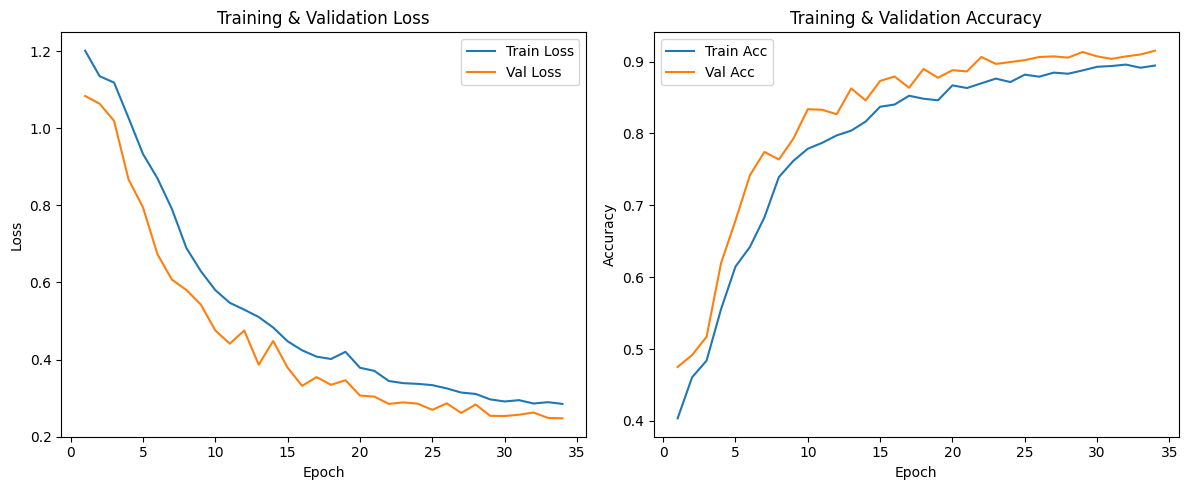

In [ ]:
epochs = range(1, len(history['train_loss']) + 1)

plt.figure(figsize=(12,5))

# Loss subplot
plt.subplot(1,2,1)
plt.plot(epochs, history['train_loss'], label='Train Loss')
plt.plot(epochs, history['val_loss'],   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Accuracy subplot
plt.subplot(1,2,2)
plt.plot(epochs, history['train_acc'], label='Train Acc')
plt.plot(epochs, history['val_acc'],   label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Testing

Classification Report:
              precision    recall  f1-score   support

      glioma       0.89      0.82      0.85       300
  meningioma       0.77      0.79      0.78       306
     notumor       0.92      0.95      0.94       405
   pituitary       0.93      0.95      0.94       300

    accuracy                           0.88      1311
   macro avg       0.88      0.88      0.88      1311
weighted avg       0.88      0.88      0.88      1311



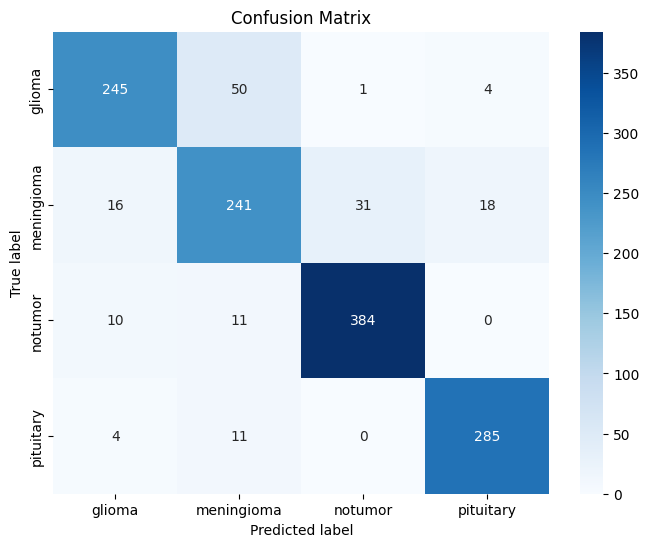

In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names,
            cmap=plt.cm.Blues)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

# Save Checkpoint

In [ ]:
os.makedirs("models", exist_ok=True)
torch.save(model.state_dict(), 'models/simple_cnn.pth')